# TP cinématique et dynamique en analyse du mouvement 2
**Charles Pontonnier - Nicolas Bideau**


## Dynamique inverse



Ce petit code python a pour objectif de réaliser l'analyse par dynamique inverse. Un fichier de fonctions accompagne ce TD pour alléger le code dans le notebook (ID.py).

conda install -c conda-forge ezc3d 

## Markerset utilisé
![alt text](markerset.png "jeu de marqueurs utilisé")

## Setup du Notebook

In [1]:
import ezc3d 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import ID #import des fonctions spécifiques au notebook

## Ouverture du fichier, récupération des données



<font color='green'>**Question 1: Le fichier est ouvert différemment que lors du TP précédent. Qu'est ce qui change ?**</font>

In [2]:
#Ouverture du fichier

c = ezc3d.c3d('DATA/marche.c3d', extract_forceplat_data=True);

point_data = c['data']['points'] #récupération trajectoires marqueurs
point_labels=c['parameters']['POINT']['LABELS']# récupération labels marqueurs
point_rate=c['parameters']['POINT']['RATE'] # récupération fréquence mocap
analog_data = c['data']['analogs'] # récupération données analogiques
analog_labels=c['parameters']['ANALOG']['LABELS'] # récupération labels analogiques
analog_rate=c['parameters']['ANALOG']['RATE'] # récupération fréquence analogique

nf_mocap=len(point_data[0][0][:]) #nombre de frames de capture
n_markers=len(point_data[0][:]) #nombre de marqueurs
n_dims=len(point_data[:]) #dimensions (3)
nf_analog=len(analog_data[0][:][:]) #nombre de frames données analogiques
t_point=np.linspace(0., nf_mocap/point_rate['value'][0], num=nf_mocap) #temps mocap
t_analog=np.linspace(0., nf_analog/analog_rate['value'][0], num=nf_analog) #temps analogique
f_mocap=point_rate['value'][0] #fréquence capture

fc=6 #Hz fréquence de coupure du filtre passe bas

g=9.81 #gravité


## Introduction des paramètres du modèle

In [3]:

#################################################
########### PARAMETRES GEOMETRIQUES #############
#################################################

pOt=np.transpose([[-74,-46,74]])/1000#création position de la hanche dans le repère local du pelvis
#position des centres de masse dans le repère local
tGt=np.transpose([[0,-190,0]])/1000 #centre de masse de la cuisse dans le repère cuisse
sGs=np.transpose([[0,-186,0]])/1000 #centre de masse de la jambe dans le repère jambe
fGf=np.transpose([[-30,-80,0]])/1000 #centre de masse du pied dans le repère pied

##############################################
########### PARAMETRES INERTIELS #############
##############################################

#cuisse
mt=8.25 #kg
It=0.1434 #kg.m²
#jambe
ms=3.21 #kg
Is=0.0463 #kg.m²
#pied
mf=0.8 #kg
If=0.0056 #kg.m²


## Construction des centres articulaires 

On cherche à présent à obtenir les centres articulaires des différentes articulations du modèle. 

![alt text](centres_articulaires.png "centres articulaires du modèle")

<font color='green'>**Question 2: Une étape supplémentaire a été ajoutée dans ce calcul. A quoi correspond cette étape et à quoi sert elle ? Modifier la fréquence de coupure pour tester l'effet du filtrage sur les données.**</font>

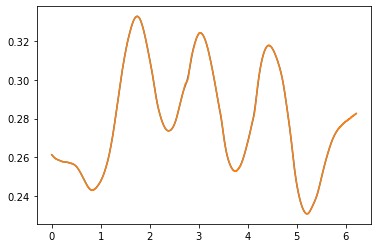

In [4]:
fc = 6

# le centre segmentaire (et articulaire) du pelvis est approximé par la moyenne des quatres marqueurs pelvis
Op=np.zeros((nf_mocap,3))
Op[:,0]=ID.LP_filter(0.25*(point_data[0][10][:]+point_data[0][11][:]+point_data[0][21][:]+point_data[0][22][:])/1000,fc,f_mocap)
Op[:,1]=ID.LP_filter(0.25*(point_data[1][10][:]+point_data[1][11][:]+point_data[1][21][:]+point_data[1][22][:])/1000,fc,f_mocap)
Op[:,2]=ID.LP_filter(0.25*(point_data[2][10][:]+point_data[2][11][:]+point_data[2][21][:]+point_data[2][22][:])/1000,fc,f_mocap)

# le centre articulaire de la hanche va faire l'objet d'un calcul spécifique ensuite

# le centre articulaire du genou est approximé par la moyenne des 2 marqueurs du genou
Os=np.zeros((nf_mocap,3))
Os[:,0]=ID.LP_filter(0.5*(point_data[0][18][:]+point_data[0][19][:])/1000,fc,f_mocap)
Os[:,1]=ID.LP_filter(0.5*(point_data[1][18][:]+point_data[1][19][:])/1000,fc,f_mocap)
Os[:,2]=ID.LP_filter(0.5*(point_data[2][18][:]+point_data[2][19][:])/1000,fc,f_mocap)

# le centre articulaire de la cheville est approximé par la moyenne des 2 marqueurs de la cheville

Of=np.zeros((nf_mocap,3))
Of[:,0]=ID.LP_filter(0.5*(point_data[0][16][:]+point_data[0][17][:])/1000,fc,f_mocap)
Of[:,1]=ID.LP_filter(0.5*(point_data[1][16][:]+point_data[1][17][:])/1000,fc,f_mocap)
Of[:,2]=ID.LP_filter(0.5*(point_data[2][16][:]+point_data[2][17][:])/1000,fc,f_mocap)

# le point situé sur le gros orteil est approximé par le marqueur gros orteil
Otoe=np.zeros((nf_mocap,3))
Of[:,0]=ID.LP_filter(point_data[0][12][:]/1000,fc,f_mocap)
Of[:,1]=ID.LP_filter(point_data[1][12][:]/1000,fc,f_mocap)
Of[:,2]=ID.LP_filter(point_data[2][12][:]/1000,fc,f_mocap)

Op_brut_0 =0.25*(point_data[0][10][:]+point_data[0][11][:]+point_data[0][21][:]+point_data[0][22][:])/1000

plt.figure(1)
plt.plot(t_point,Op[:,0])
plt.plot(t_point,Op_brut_0)
plt.show()

## Cinématique inverse

Cette partie du code réalise les mêmes étapes que celles détaillées dans le TP1 "cinématique"

In [9]:
markers=np.zeros((n_markers,n_dims-1)) #donnée temporaire contenant l'ensemble des positions de marqueurs à une frame donnée

Ot=np.zeros((nf_mocap,3)) # création du conteneur pour la position de la hanche dans le repère monde

# On définit d'abord les vecteurs y des différents segments au cours du temps

yp=np.zeros((nf_mocap,3)) #axe y du pelvis au cours du temps
yt=np.zeros((nf_mocap,3)) #axe y de la cuisse au cours du temps
ys=np.zeros((nf_mocap,3)) #axe y de la jambe au cours du temps
yf=np.zeros((nf_mocap,3)) #axe y du pied au cours du temps

# On définit ensuite les angles q1 flexion de hanche, q2 flexion de genou, q3 flexion de cheville
q1=np.zeros((nf_mocap)) # création du conteneur pour l'angle q1
q2=np.zeros((nf_mocap)) # création du conteneur pour l'angle q2
q3=np.zeros((nf_mocap)) # création du conteneur pour l'angle q3

for f in range(0,nf_mocap):
    for i in range(0,n_markers): 
        markers[i,0]=point_data[0][i][f]
        markers[i,1]=point_data[1][i][f]
        markers[i,2]=point_data[2][i][f]
        oRp=ID.Rp(markers) #calcul, à chaque frame, de la matrice du oRp (pelvis dans monde)
        yp[f,:]=[oRp[0,1],oRp[1,1],oRp[2,1]]
        Ot[f,:]=np.transpose(oRp@pOt)+Op[f,:] #calcul de la position de la hanche dans le repère monde 

Ot=ID.LP_filter_vec3(Ot,fc,f_mocap) #filtrage de la position de la hanche dans le repère monde

for f in range(0,nf_mocap):   
    yt[f,:]=(Ot[f,:]-Os[f,:])/np.linalg.norm(Ot[f,:]-Os[f,:])# calcul de yt au cours du temps --> on construit le vecteur Ot-Os et on normalise
    ys[f,:]=(Os[f,:]-Of[f,:])/np.linalg.norm(Os[f,:]-Of[f,:])# calcul de ys au cours du temps --> on construit le vecteur Os-Of et on normalise
    yf[f,:]=(Of[f,:]-Otoe[f,:])/np.linalg.norm(Of[f,:]-Otoe[f,:])# calcul de yf au cours du temps --> on construit le vecteur Of-Otoe et on normalise

    q1[f]=np.arccos(yt[f,:]@np.transpose(yp[f,:]))
    q2[f]=np.arccos(ys[f,:]@np.transpose(yt[f,:]))
    q3[f]=np.arccos(yf[f,:]@np.transpose(ys[f,:]))-np.pi/2 #attention l'angle est décalé de -pi/2 pour respecter la position anatomique du pied


c:\Users\PC\OneDrive\Bureau\3A\Modélisation bioméca\DIGISPORT_BIOMECA\Exercice - membres inférieurs\ID.py:17: RuntimeWarning: invalid value encountered in true_divide
  zp=(markers[21,:]-markers[10,:])/np.linalg.norm(markers[21,:]-markers[10,:]) # RFWT-LFWT
c:\Users\PC\OneDrive\Bureau\3A\Modélisation bioméca\DIGISPORT_BIOMECA\Exercice - membres inférieurs\ID.py:18: RuntimeWarning: invalid value encountered in true_divide
  xp=(0.5*(markers[21,:]+markers[10,:])-0.5*(markers[22,:]+markers[11,:]))/np.linalg.norm(0.5*(markers[21,:]+markers[10,:])-0.5*(markers[22,:]+markers[11,:]))


## Calcul des positions, vitesses et accélérations des centres de masse

<font color='green'>**Question 3: Calculer pour chaque frame la position des centres de masses des segments dans le repère monde. Exploiter pour cela les centres articulaires calculés précedemment ainsi que les matrices de rotation des différents solides par rapport au repère monde. Regarder la fonction "rotz" dans le fichier ID.py pour construire ces matrices.**</font>

In [15]:
############################################################
########### POSITIONS, VITESSES, ACCELERATIONS #############
############################################################

# calcul et filtrage des centres de masse dans le repère global
oGt=np.zeros((nf_mocap,3))
oGs=np.zeros((nf_mocap,3))
oGf=np.zeros((nf_mocap,3))

#####AJOUTER ICI LE CODE DE CALCUL DES TROIS QUANTITES CI-DESSUS

for f in range(0,nf_mocap):
    for i in range(0,n_markers): 
        markers[i,0]=point_data[0][i][f]
        markers[i,1]=point_data[1][i][f]
        markers[i,2]=point_data[2][i][f]
        oRp=ID.Rp(markers) #calcul, à chaque frame, de la matrice du oRp (pelvis dans monde)
    pRt = ID.rotz(q1[f])
    tRs = ID.rotz(q2[f])
    sRf = ID.rotz(q3[f] + np.pi/2)
    oGt[f,:] = Ot[f,:] + np.transpose(oRp@pRt@tGt)
    oGs[f,:] = Ot[f,:] + np.transpose(oRp@pRt@tRs@sGs)
    oGf[f,:] = Ot[f,:] + np.transpose(oRp@pRt@tRs@sRf@fGf)

oGt=ID.LP_filter_vec3(oGt,fc,f_mocap)
oGs=ID.LP_filter_vec3(oGs,fc,f_mocap)
oGf=ID.LP_filter_vec3(oGf,fc,f_mocap)

# calcul des vitesses des centres de masse par différences finies +filtrage
vGt=ID.diff_vec3(oGt,1/f_mocap)
vGs=ID.diff_vec3(oGs,1/f_mocap)
vGf=ID.diff_vec3(oGf,1/f_mocap)
vGt=ID.LP_filter_vec3(vGt,fc,f_mocap)
vGs=ID.LP_filter_vec3(vGs,fc,f_mocap)
vGf=ID.LP_filter_vec3(vGf,fc,f_mocap)
# calcul des accélérations des centres de masse par différences finies + filtrage
aGt=ID.diff_vec3(vGt,1/f_mocap)
aGs=ID.diff_vec3(vGs,1/f_mocap)
aGf=ID.diff_vec3(vGf,1/f_mocap)
aGt=ID.LP_filter_vec3(aGt,fc,f_mocap)
aGs=ID.LP_filter_vec3(aGs,fc,f_mocap)
aGf=ID.LP_filter_vec3(aGf,fc,f_mocap)

# filtrage des coordonnées articulaires 
q1=ID.LP_filter(q1,fc,f_mocap)
q2=ID.LP_filter(q2,fc,f_mocap)
q3=ID.LP_filter(q3,fc,f_mocap)
# vitesses articulaires par différences finies + filtrage
dq1=ID.LP_filter(ID.diff2(q1,1/f_mocap),fc,f_mocap)
dq2=ID.LP_filter(ID.diff2(q2,1/f_mocap),fc,f_mocap)
dq3=ID.LP_filter(ID.diff2(q3,1/f_mocap),fc,f_mocap)
# accélérations articulaires par différences finies + filtrage
ddq1=ID.LP_filter(ID.diff2(dq1,1/f_mocap),fc,f_mocap)
ddq2=ID.LP_filter(ID.diff2(dq2,1/f_mocap),fc,f_mocap)
ddq3=ID.LP_filter(ID.diff2(dq3,1/f_mocap),fc,f_mocap)

## Extraction des données de la plateforme 2

Le code suivant permet d'extraire les données de plateforme stockées dans le C3D. Les données sont directement exprimées dans le repère global ce qui facilite fortement leur usage pour réaliser l'analyse par dynamique inverse. Par contre la présence de "trous" dans les données oblige à les pré-traiter (voir fonction "replace_nan" dans ID.py). Les données sont resamplées à la fréquence de capture et filtrées.

<font color='green'>**Question 4: Tracer les forces de réaction de la plateforme en fonction du temps. Le résultat vous parait-il cohérent ?**</font>

In [16]:

pf_1 = c["data"]["platform"][1]  # sélection de la plateforme n°2

[GRF1,CoP1]=ID.generate_GRF(pf_1) #extraction des forces et du centre de pression dans le repère monde
CoP1=ID.replace_nan(CoP1,1.)
CoP1rs=ID.resample_vec3(CoP1,nf_mocap)

CoP1rs=np.transpose(ID.LP_filter_vec3(np.transpose(CoP1rs),fc,f_mocap))

GRF1rs=ID.resample_vec3(GRF1,nf_mocap)
GRF1rs=np.transpose(ID.LP_filter_vec3(np.transpose(GRF1rs),fc,f_mocap))

#suppression des données sur les frames de double support sur la plateforme
for i in range(1629-624,len(GRF1rs[0,:])):
    GRF1rs[0,i]=0
    GRF1rs[1,i]=0
    GRF1rs[2,i]=0
    

## Calcul de la dynamique inverse

On reprend exactement les structures et notations des slides pour réaliser ce calcul. Pour rappel, le bilan des actions mécaniques sur chacun des solides peut être résumé comme il suit :

![alt text](recap_BAME.png "Bilan des actions mécaniques extérieures")

<font color='green'>**Question 5: Pour chaque frame, calculer les matrices de rotation des différents segments, puis réaliser l'équilibre dynamique pour chaque solide. Suivre pour cela le formalisme du cours. Attention à bien projeter dans les bonnes bases les différentes quantités à l'aide des matrices de rotations, et à ramener les couples aux centres articulaires systématiquement.**</font>

In [23]:

###########################################
########### DYNAMIQUE INVERSE #############
###########################################

Ff=np.zeros((3,nf_mocap))#efforts intersegmentaires jambe -> pied
Gf=np.zeros((3,nf_mocap)) # couple articulaire cheville

Fs=np.zeros((3,nf_mocap))#efforts intersegmentaires cuisse -> jambe
Gs=np.zeros((3,nf_mocap)) # couple articulaire genou

Ft=np.zeros((3,nf_mocap))#efforts intersegmentaires pelvis -> cuisse
Gt=np.zeros((3,nf_mocap)) # couple articulaire hanche

for f in range(0,nf_mocap):
    #calculs préliminaires: matrices de rotation

    for i in range(0,n_markers): 
        markers[i,0]=point_data[0][i][f]
        markers[i,1]=point_data[1][i][f]
        markers[i,2]=point_data[2][i][f]
        oRp=ID.Rp(markers) #calcul, à chaque frame, de la matrice du oRp (pelvis dans monde)
    pRt = ID.rotz(q1[f])
    tRs = ID.rotz(q2[f])
    sRf = ID.rotz(q3[f] + np.pi/2)

    oRt = oRp@pRt
    oRs = oRt@tRs
    oRf = oRs@sRf

    #####PIED#####
    ##effort sur le pied

    #définir la résultante de l'effort   
    grf = GRF1rs[:,f]

    #transporter le moment en Of
    mgrf = np.cross(CoP1rs[:,f]-np.transpose(Of[f,:]), grf)

    #projeter résultante et moment dans Rf
    grf = np.transpose(oRf)@grf
    mgrf = np.transpose(oRf)@mgrf

    ##poids du pied

    #définir la résultante de l'effort 
    pf = np.transpose([0,0,-mf*g])

    #transporter le moment en Of
    mpf = np.cross(np.transpose(oGf[f,:] - Of[f,:]),pf)

    #projeter résultante et moment dans Rf
    pf = np.transpose(oRf)@pf
    mpf = np.transpose(oRf)@mpf

   
    #quantités d'accélération (torseur dynamique) du pied en Of 

    #définir la résultante dynamique
    af = np.transpose(mf*aGf[f,:])

    #transporter le moment en Of (attention il existe un moment dynamique en Gf)
    maf_gf=[0,0,If*(ddq1[f]+ddq2[f]+ddq3[f])] # Moment dynamique en Gf et projeté dans Rf
    maf = maf_gf+np.transpose(oRf)@np.cross(np.transpose(oGf[f,:]-Of[f,:]),af) # Moment dynamique en Of et projeté dans Rf

    #projeter résultante et moment dans Rf
    af = np.transpose(oRf)@af
    
    #On résout pour le pied: le torseur dynamique=la somme des torseurs des actions extérieures
    
    Ff[:,f]=af-pf-grf
    Gf[:,f]=maf-mpf-mgrf

    #####JAMBE#####
    
    #poids de la jambe
    
    #définir la résultante de l'effort
    #transporter le moment en Os
    #projeter résultante et moment dans Rs
    
    
    
    #quantités d'accélération (torseur dynamique) de la jambe en Os

    #définir la résultante dynamique
    #transporter le moment en Os (attention il existe un moment dynamique en Gs)
    #projeter résultante et moment dans Rs
    
    #Efforts pied -> jambe
    
    #inverser et projeter dans Rs la résultante jambe->pied calculée précedemment
    #transporter le moment de cheville en Os et le projeter dans Rs
    
    
    #On résout pour la jambe: le torseur dynamique=la somme des torseurs des actions extérieures
    #Fs[:,f]=
    #Gs[:,f]=
 
    #####CUISSE#####
    
    #poids de la cuisse

    #définir la résultante de l'effort
    #transporter le moment en Ot
    #projeter résultante et moment dans Rt
    
    #quantités d'accélération (torseur dynamique) de la cuisse en Ot

    #définir la résultante dynamique
    #transporter le moment en Ot (attention il existe un moment dynamique en Gt)
    #projeter résultante et moment dans Rt
    
    #Efforts jambe -> cuisse
    #inverser et projeter dans Rt la résultante cuisse->jambe calculée précedemment
    #transporter le moment de genou en Ot et le projeter dans Rt
    
    
    #On résout pour la jambe
    #Ft[:,f]=
    #Gt[:,f]=



## Tracé des couples articulaires

On choisit pour ce tracé de partir du décollage du pied droit (right toe off) jusqu'au début de la phase de double appui, pour laquelle le pied gauche se pose sur la même plateforme que le pied droit et vient donc rendre inexploitable la suite du cycle (double support). 

<font color='green'>**Question 6: Tracé à l'aide du temps normalisé l'évolution des couples (normalisés par la masse du sujet qui est de 65kg) au cours du temps.**</font>

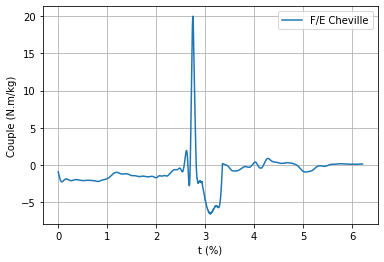

In [34]:


off=624 # offset
#cycle complet
t1=1275 #right toe off
t3=1679 #right toe off

#fin du tracé
t2=1629 #double support

#instant de la pose du pied droit sur la plateforme
t4=1428 # right heel strike

nf_cycle=len(t_point[t1:t3]) #récupération de la longueur du cycle de marche
nf_trace=len(t_point[t1:t2]) #récupération de la longueur du tracé
t_percent=np.linspace(0., 100, num=nf_cycle) #temps normalisé entre 0 et 100%, long comme le cycle de marche


#ajouter les tracés ici

plt.plot(t_point,Gf[0])
plt.xlabel('t (%)')
plt.ylabel('Couple (N.m/kg)')
plt.legend(['F/E Cheville','F/E Genou','F/E Hanche'])
plt.grid()
# plt.savefig('test.png')
plt.show()
